# Working with data from AnyBody

There are several ways to output data from AnyBody. The most convinient way to export a few variables from AnyBody is through the API in AnyPyTools. This is what you saw in the previous tutorials which used the 'Export' helper class to generated macros which export specific variables. 

Another option is to have AnyBody write specific variables to a file by adding the 'AnyOutputFile' class to the AnyBody model, or exporting an HDF5 file with all data from a simulation. In these cases AnyPyTools has methods to make it easier to get data into Python for futher analysis. 

Here we go through the different methods. 

## Output data through AnyPyTools

Using the AnyPyTools API directly is the easiest way to export data when you only need to export a limited number of variables.

In the following we use the toy example from the "Generating Macros" tutorial. We crate 6 macros with different parameters and collect the result from running the simulations. Data is exported by including the `Export("<folder/variable name>")` command. If a folder is specified all variables below that level is exported.

> **Note:** Remember to specifiy the variables in study `.Ouput.*` folder if you need the results of a simulation. 

In [1]:
from anypytools import AnyMacro, AnyPyProcess, macro_commands as mc

macro_list = []
for length in [0.02, 0.03, 0.04, 0.05, 0.06, 0.07]:
    macro = [
        mc.Load("Knee.any"),
        mc.SetValue("Main.MyModel.PatellaLigament.DriverPos", length),
        mc.RunOperation("Main.MyStudy.InverseDynamics"),
        mc.Export("Main.MyStudy.Output.Abscissa.t", "time"),
        mc.Export("Main.MyStudy.Output.MaxMuscleActivity", "MaxMuscleActivity"),
        mc.Export("Main.MyModel.PatellaLigament.DriverPos", "PatellaLength"),
    ]
    macro_list.append(macro)

app = AnyPyProcess()
results = app.start_macro(macro_list)

Output()

Completed: 6


Now the variable `results` is a list of dictionaries with the output from AnyBody. This is a very flexible format that can hold any kind of data we can output from AnyBody.

In [2]:
results[2]["PatellaLength"]

array([0.04])

If we plot this data we need to do some manual work. I.e. looping over the list and plot individual variables. 

However, it can be made much easier if we convert data into a Pandas DataFrame. A DataFrame is like an excel spreadsheet. Most python plotting libries can plot directly from that.

> *Note:* Not all data is suitable for convertion to a DataFrame. You data needs the same type of output in every simulation. Also, a DataFrame is 2 dimensional so higher dimensional data (like vectors) are flattend with x/y/z components into seperate collumns.

In [3]:
import numpy as np

df = results.to_dataframe(index_var='time')
df

time  MaxMuscleActivity  PatellaLength
0 0   0.000000           0.022982           0.02
  1   0.024242           0.023878           0.02
  2   0.048485           0.025233           0.02
  3   0.072727           0.027028           0.02
  4   0.096970           0.029236           0.02
...        ...                ...            ...
5 95  2.303030           0.010652           0.07
  96  2.327273           0.009699           0.07
  97  2.351515           0.008954           0.07
  98  2.375758           0.008414           0.07
  99  2.400000           0.008077           0.07

[600 rows x 3 columns]

The `index_var` specifies which variable becomes the x axis in the dataset. Other variables which doesn't have the same first dimension as the `index_var` will be repeated along that dimension. This allows you to export which are not a function of time. Those variables then become constants.

Line plots only work if you have the same x axis across all simulations. Otherwise, you need to interpolate the data.

Now plotting the data is really simple with a library like for example [seaborn](https://seaborn.pydata.org/):

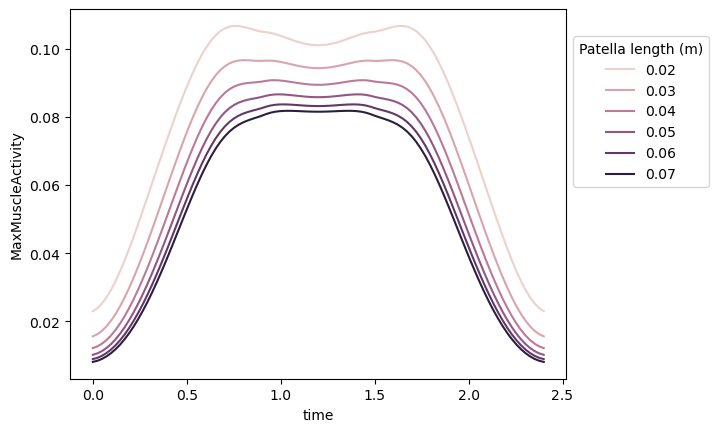

In [4]:
import seaborn as sns

g = sns.lineplot(
    data=df,
    x="time",
    y="MaxMuscleActivity",
    hue="PatellaLength",
)
g.legend(title="Patella length (m)", loc='lower left', bbox_to_anchor=(1, 0.5));


## Working with AnyOutputFiles

The `AnyOutputFile` class is an other methods of exporting data from AnyBody. It is a AnyScript class in the AnyBody Modeling System which produces text files with data when a simulation is run. These text files are very similar to comma seperated files with some additional header information. 

Here is an example below:

In [5]:
%%writefile TestOutput.csv
---- AnyBody Output File ---------------------------------
Study Main.MyStudy
Operation Main.MyStudy.InverseDynamics
----------------------------------------------------------
Constants (Name = Value) 
Main.MyStudy.FileOutput.ConstName = HelloWorld
Main.MyStudy.nStep = 5
Main.MyModel.Femur.Knee.sRel = { 0.000000000000000e+000, -3.000000000000000e-001,  0.000000000000000e+000}
----------------------------------------------------------
Variables (Column# Name) 
col0  Main.MyStudy.t
col1  Main.MyStudy.MomentArm
----------------------------------------------------------
Main.MyStudy.t,Main.MyStudy.MomentArm
 0.000000000000000e+000, 3.517106754087954e-002
 6.000000000000000e-001, 4.256597756479537e-002
 1.200000000000000e+000,-2.495531558514929e-004
 1.800000000000000e+000, 4.256603812471121e-002
 2.400000000000000e+000, 3.517106649790244e-002


Writing TestOutput.csv


It is not particular difficult to read. You could write you own custom Python, Matlab code to parse the values. But **`anypytools`**  has a few convinience functions that makes it very easy to load the files. 

This is especially usefull for the header information which can be annoying to parse manually. 

In [6]:
from anypytools.datautils import read_anyoutputfile

data, header, constants = read_anyoutputfile("TestOutput.csv")

The function returns three outputs. An array with the time dependent data, and a list of header names:

In [7]:
header, data

(['Main.MyStudy.t', 'Main.MyStudy.MomentArm'],
 array([[ 0.00000000e+00,  3.51710675e-02],
        [ 6.00000000e-01,  4.25659776e-02],
        [ 1.20000000e+00, -2.49553156e-04],
        [ 1.80000000e+00,  4.25660381e-02],
        [ 2.40000000e+00,  3.51710665e-02]]))

and python dictonary with constant values:

In [8]:
constants

{'Main.MyStudy.FileOutput.ConstName': 'HelloWorld',
 'Main.MyStudy.nStep': 5.0,
 'Main.MyModel.Femur.Knee.sRel': array([ 0. , -0.3,  0. ])}

## Working with HDF5 files

Sometimes, it can be convenient to save the entire model along with all its data (although this can be several hundred megabytes). It is useful if we later want to analyze other output variables from the model. It can also be useful if we want to load the data in the AnyBody graphical user application and replay the result.

AnyBody has a feature to save the output of a study to an HDF5 file. And like most things in AnyBody, this can also be done with a macro command. 

Let us try this with the model from the previous tutorials.

In [9]:
from anypytools.macro_commands import Load, RunOperation, SaveData

macrolist = [
  Load('Knee.any'),
  RunOperation('Main.MyStudy.Kinematics'),
  SaveData('Main.MyStudy', 'output.anydata.h5'),
]
macrolist

[load "Knee.any",
 operation Main.MyStudy.Kinematics
 run,
 classoperation Main.MyStudy.Output "Save data" --type="Deep" --file="output.anydata.h5"]

 Here we have added a "`Save data`" classoperation to the macro. 

In [10]:
from anypytools import AnyPyProcess 
app = AnyPyProcess()

app.start_macro(macrolist);

Output()

Completed: 1


The data stored in the file **output.anydata.h5** can be re-loaded in the AnyBody GUI application. 

To do this; load the model, and then right click the `Main.MyStudy.Output` folder and select "Load data". 

These files can also be loaded into Matlab or Python. In python this is done using the *`h5py`* module



In [11]:
import numpy as np
import h5py

h5file = h5py.File('output.anydata.h5', "r")
data = np.array( h5file['/Output/MomentArm'] )
h5file.close()
print(data)

[0.03517107 0.03518544 0.03522538 0.03529129 0.03538355 0.03550231
 0.03564761 0.03581929 0.03601707 0.03624048 0.03648895 0.03676178
 0.03705816 0.03737724 0.03771812 0.03807991 0.03846173 0.03886281
 0.03928244 0.03972002 0.0401751  0.04064731 0.04113638 0.04164206
 0.04216406 0.04270195 0.04325503 0.04382223 0.04440197 0.04499208
 0.04558969 0.04619126 0.04679259 0.04738895 0.04797527 0.04854637
 0.0490972  0.04962319 0.05012044 0.0505859  0.051017   0.0514114
 0.05176698 0.0520819  0.05235456 0.05258365 0.05276812 0.05290715
 0.05300015 0.05304675 0.05304675 0.05300015 0.05290715 0.05276812
 0.05258365 0.05235456 0.0520819  0.05176698 0.0514114  0.051017
 0.0505859  0.05012044 0.04962319 0.0490972  0.04854637 0.04797527
 0.04738895 0.04679259 0.04619126 0.04558969 0.04499208 0.04440197
 0.04382223 0.04325503 0.04270195 0.04216406 0.04164206 0.04113638
 0.04064731 0.0401751  0.03972002 0.03928244 0.03886281 0.03846173
 0.03807991 0.03771812 0.03737724 0.03705816 0.03676178 0.0364889

The data structure of the HDF5 files can, unfortunately, be very confusing. AnyBody does not save duplicate copies of the same data. If there are multiple references to the same folder, only one will be present in the HDF5 file. 
In our model `Knee.any` we have a reference to the **`Knee`** joint folder just before the **`Model`** folder in the study section. Thus, all variables inside the **`Knee`** folder cannot be accessed with the path '/Output/Model/Knee/...', but only through the path of the reference '/Output/kneeref/...'.

We can see the problem in the following code snippet:

In [12]:
with h5py.File('output.anydata.h5', "r") as f:
    print('/Output/Model/Knee/Pos' in f)
    print('/Output/kneeref/Pos' in f)


False
False


This makes it difficult to find the correct path in large models with many references. AnyPyTools contains a wrapper for the h5py module, which automatically locates the right data, no matter what path is used. Using this module, we can easily locate the data. 

In [13]:
import anypytools.h5py_wrapper as h5py2
with h5py2.File('output.anydata.h5', "r") as f:
    print('/Output/Model/Knee/Pos' in f)
    print('/Output/kneeref/Pos' in f)

True
True


The h5py wrapper will also let us use the AnyScript variable names directly, so we don't have to replace every . (dot) with a / (slash), and remove the stuff before the Output folder. 

In [14]:
with h5py2.File('output.anydata.h5', "r") as f:
    momentarm = np.array(f['/Output/MomentArm']) # Standard h5py notation
    momentarm = np.array(f['Output.MomentArm'])  # dot notation
    kneeangle = np.array(f['Main.MyStudy.Output.Model.Knee.Pos']) # dot notation with full path
    

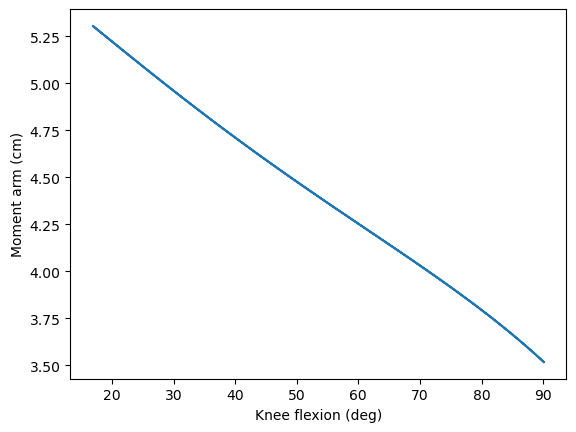

In [15]:
%matplotlib inline
from numpy import degrees
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.plot(degrees(kneeangle), 100*momentarm)

plt.xlabel('Knee flexion (deg)')
plt.ylabel('Moment arm (cm)');